In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import operator

from matplotlib import pyplot as plt
import seaborn as sns

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns 

from itertools import product

import xgboost
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor

import shap

In [2]:
class ETL:
    def __init__(self):
        self.common_data_path = '../input/competitive-data-science-predict-future-sales'

        self.sales_train = None
        self.shops = None
        self.test = None
        self.item_categories = None
        self.items = None

    def extract(self) -> None:
        self.sales_train = pd.read_csv(f'{self.common_data_path}/sales_train.csv')
        self.shops = pd.read_csv(f'{self.common_data_path}/shops.csv')
        self.test = pd.read_csv(f'{self.common_data_path}/test.csv')
        self.item_categories = pd.read_csv(f'{self.common_data_path}/item_categories.csv')
        self.items = pd.read_csv(f'{self.common_data_path}/items.csv')

    def transform(self) -> None:
        self.sales_train.date = pd.to_datetime(self.sales_train.date)
        self.sales_train['month'] = self.sales_train.date.dt.to_period('M')

        self.sales_train = self.sales_train[self.sales_train.item_cnt_day > -2]
        self.sales_train = self.sales_train[self.sales_train.item_price < 300_000]
        self.sales_train = self.sales_train[self.sales_train.month < '2015-11']

        id_of_duplicated_shops = {10: 11, 0: 57, 1: 58, 40: 39}

        for k, v in id_of_duplicated_shops.items():
            self.shops = self.shops[self.shops.shop_id != k]
            self.sales_train.loc[self.sales_train.shop_id == k, 'shop_id'] = v

        self.test.loc[self.test.shop_id == 10, 'shop_id'] = 11

        self.shops.shop_name = self.shops.shop_name.map(lambda x: x.lstrip('!'))

        self.shops['city'] = self.shops.shop_name.str.split(' ').map(lambda x: x[0])
        self.shops['category'] = self.shops.shop_name.str.split(' ').map(lambda x: x[1])

        shop_enc = LabelEncoder()
        self.shops['shop_category'] = shop_enc.fit_transform(self.shops['category'])
        shop_city_enc = LabelEncoder()
        self.shops['shop_city'] = shop_city_enc.fit_transform(self.shops['city'])
        self.shops = self.shops[['shop_id', 'shop_category', 'shop_city']]

        self.sales_train = self.sales_train.drop_duplicates(
            subset=['date', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day'],
            keep='last')

        self.items.item_name = self.items.item_name.map(lambda x: x.lstrip('!*/'))

        same_items_regardless_case = self.items[self.items.item_name.map(lambda x: x.lower()).duplicated()]
        fully_same = self.items.groupby(self.items.item_name, as_index=False).size().query('size > 1')
        fully_same_item_names = fully_same.item_name.values

        self.items = self.items[self.items.item_id != 12]
        self.sales_train = self.sales_train[self.sales_train.item_id != 12]

        same_items_regardless_case_names = same_items_regardless_case[~same_items_regardless_case.item_name.isin(
            fully_same_item_names)].item_name

        same_items = self.items[self.items.item_name.map(lambda x: x.lower()).isin(
            same_items_regardless_case_names.map(lambda x: x.lower()))]

        same_items_upper_case = same_items[same_items.item_name.str.endswith('(Регион)')]
        same_items_lower_case = same_items[same_items.item_name.str.endswith('(регион)')]

        self.items = self.items[~self.items.item_id.isin(same_items_lower_case.item_id)]

        self.sales_train.loc[self.sales_train.item_id.isin(same_items_lower_case.item_id), 'item_id'] = \
            self.sales_train[self.sales_train.item_id.isin(same_items_lower_case.item_id)].item_id.map(lambda x: x - 1)

        self.test.loc[self.test.item_id.isin(same_items_lower_case.item_id), 'item_id'] = \
            self.test[self.test.item_id.isin(same_items_lower_case.item_id)].item_id.map(lambda x: x - 1)

        self.items = self.items[self.items.item_id != 13012]
        self.sales_train.loc[self.sales_train.item_id == 13012, 'item_id'] = 13011
        self.test.loc[self.test.item_id == 13012, 'item_id'] = 13011

        self.items['name1'], self.items['name2'] = self.items['item_name'].str.split('[', 1).str
        self.items['name1'], self.items['name3'] = self.items['item_name'].str.split('(', 1).str

        self.items['name2'] = self.items['name2'].str.replace('\W+', ' ').str.lower()
        self.items['name3'] = self.items['name3'].str.replace('\W+', ' ').str.lower()

        self.items = self.items.fillna('0')

        self.items['name2'] = LabelEncoder().fit_transform(self.items['name2'])
        self.items['name3'] = LabelEncoder().fit_transform(self.items['name3'])

        self.items.drop(['item_name', 'name1'], axis=1, inplace=True)

        self.item_categories['type_code'] = self.item_categories['item_category_name'].apply(
            lambda x: x.split(' ')[0]).astype(str)

        categories = []
        for cat in self.item_categories['type_code'].unique():
            if len(self.item_categories[self.item_categories['type_code'] == cat]) > 3:
                categories.append(cat)
        self.item_categories['type_code'] = self.item_categories['type_code'].apply(
            lambda c: c if c in categories else 'other')

        self.item_categories['type_code'] = LabelEncoder().fit_transform(self.item_categories['type_code'])
        self.item_categories['subcat'] = self.item_categories['item_category_name'].apply(lambda x: x.split('-')).apply(
            lambda x: x[1].strip() if len(x) >= 2 else x[0].strip())

        self.item_categories['subcat'] = LabelEncoder().fit_transform(self.item_categories['subcat'])
        self.item_categories.drop('item_category_name', axis=1, inplace=True)

    def load(self):
        
        return self.sales_train, self.shops, self.test, self.item_categories, self.items

In [3]:
etl = ETL()
etl.extract()
etl.transform()

sales, shops, test, item_categories, items = etl.load()

Columnar iteration over characters will be deprecated in future releases.
Columnar iteration over characters will be deprecated in future releases.
The default value of regex will change from True to False in a future version.
The default value of regex will change from True to False in a future version.


In [4]:
class RollingWindowCV(object):
    
    def __init__(self, train_period=12, test_period=1, gap=0):
        self.n_splits = 0
        self.train_period = train_period
        self.test_period = test_period
        self.gap = gap
    
    def split(self, data, 
              date_column='date_block_num', 
              target_column='item_cnt_month', 
              clip_range: list = [0, 20]):

        try:
            data[date_column]
        except:
            raise KeyError(date_column)
        
        start_train = int(data[date_column].min())
        end_train = start_train + self.train_period
        start_test = end_train + self.gap
        end_test = start_test + self.test_period

        while end_test < data[date_column].max():
            train_indices = list(data[(data[date_column] >= start_train) & 
                                     (data[date_column] < end_train)].index)


            test_indices = list(data[(data[date_column] >= start_test) &
                                    (data[date_column] < end_test)].index)
            
            print("Train period:", start_train,"-" , end_train, ", Test period", start_test, "-", end_test,
                  "# train records", len(train_indices), ", # test records", len(test_indices))

            start_train = end_train + 1
            end_train = start_train + self.train_period
            start_test = end_train + self.gap
            end_test = start_test + self.test_period
            
            self.n_splits += 1
            
            train_data = data.loc[train_indices]
            X_train = train_data.drop([target_column], axis=1).fillna(0)
            y_train = train_data[target_column].clip(*clip_range)
            
            valid_data = data.loc[test_indices]
            X_valid = valid_data.drop([target_column], axis=1).fillna(0)
            y_valid = valid_data[target_column].clip(*clip_range)
            
            yield X_train, y_train, X_valid, y_valid
    
    
    def get_n_splits(self):
        return self.n_splits 

In [5]:
class TrainEngineering:
    def __init__(self, data):
        self.data: pd.DataFrame = data
        self.train: pd.DataFrame = None
        
    def create_train(self,
                     cols: list, 
                     data_column: str, 
                     unique_cols: list):
        train = []
        for data_block in range(self.data[data_column].nunique()):
            train_temp = self.data[self.data[data_column] == data_block]
            train.append(np.array(list(product([data_block], *[train_temp[unique_col].unique() 
                                                                  for unique_col in unique_cols]))))

        train = pd.DataFrame(np.vstack(train), columns=cols)
        self.train = train.sort_values(cols)
        
    def add_aggregated_data(self,
                            groupby_cols: list,
                            agg_col_funcs: dict,
                            agg_cols_name: list):
        aggregated_data = self.data.groupby(groupby_cols).agg(agg_col_funcs)
        aggregated_data.columns = agg_cols_name
        aggregated_data.reset_index(inplace=True)
        
        self.merge_tables([(groupby_cols, aggregated_data)])
        self.train = self.train.fillna(0)
        
    def add_lags(self, periods, lag_cols, 
                 date_block_column='date_block_num', 
                 agg_cols=['date_block_num', 'shop_id', 'item_id']):
        for lag_col in lag_cols:
            aggregated = self.train[[*agg_cols, lag_col]]
            for per in periods:
                shifted = aggregated.copy()
                shifted.columns = [*agg_cols, lag_col + "_lag_" + str(per)]
                shifted[date_block_column] = shifted[date_block_column] + per
                self.merge_tables([(agg_cols, shifted)])
                self.train = self.train.fillna(0)
        
    def merge_tables(self, table_keys: list):
        for key, table in table_keys:
            self.train = pd.merge(self.train, table, on=key, how='left')
    
    def concat(self, data, cols: list):
        self.train = pd.concat([self.train, data], 
                               ignore_index=True, 
                               sort=False, 
                               keys=cols).fillna(0)
            
    def get_train(self):
        return self.train

In [6]:
class TestEngineering:
    def __init__(self, data):
        self.test: pd.DataFrame = data
            
    def select_features(self, cols: list):
        self.test = self.test[cols]
        
    def add_column(self, col: str, values: any):
        self.test[col] = values

    def get_test(self):
        return self.test

In [7]:
class ModelCV:
    def __init__(self,
                 train_data: pd.DataFrame,
                 test_data: pd.DataFrame,
                 items: pd.DataFrame, 
                 item_categories: pd.DataFrame, 
                 shops: pd.DataFrame,
                 train_eng_class, 
                 test_eng_class, 
                 cv_class):
        self.train_data = train_data
        self.test_data = test_data
        self.items = items
        self.item_categories = item_categories
        self.shops = shops
        self.train_eng_class = train_eng_class
        self.test_eng_class = test_eng_class
        self.cv_class = cv_class
        
        self.train_eng = None
        self.test_eng = None
        
    def create_train_table(self):
        self.train_eng = self.train_eng_class(self.train_data)

        self.train_eng.create_train(['date_block_num', 'shop_id', 'item_id'], 
                               'date_block_num', 
                               ['shop_id', 'item_id'])

        self.train_eng.add_aggregated_data(['date_block_num', 'shop_id', 'item_id'], 
                                      {'item_cnt_day': 'sum'},
                                      ['item_cnt_month'])
        
        self.test_eng = self.test_eng_class(self.test_data)
        
        self.test_eng.select_features(['shop_id', 'item_id'])
        self.test_eng.add_column('date_block_num', self.train_data.date_block_num.max() + 1)
        
        self.train_eng.concat(self.test_eng.get_test(), ['date_block_num', 'shop_id', 'item_id'])
        self.train = self.train_eng.get_train()
        
        self.train_eng.merge_tables([('item_id', self.items), 
                        ('item_category_id', self.item_categories),
                        ('shop_id', self.shops)])
        
        self.train_eng.add_lags([1, 2, 12], ['item_cnt_month'])
        
        self.train_data = self.train_eng.get_train()
        
    def get_splits(self, traget_col: str, train_period: int = 12):
        cv = self.cv_class(train_period=train_period)
        for X_train, y_train, X_valid, y_valid in cv.split(self.train_data):
            if X_train is not None:
                yield X_train, y_train, X_valid, y_valid
            else: 
                raise StopIteration

In [8]:
tscv = ModelCV(sales, test, items, 
               item_categories, shops, TrainEngineering, 
               TestEngineering, RollingWindowCV)
tscv.create_train_table()

In [9]:
models = []
for X_train, y_train, X_valid, y_valid in tscv.get_splits('item_cnt_month', 12):

    model = XGBRegressor(
       n_estimators=800,
       min_child_weight=0.8, 
       colsample_bytree=0.8, 
       subsample=0.8, 
       eta=0.1,
       eval_metric=['rmse'],
       early_stopping_rounds=10,
       used_ram_limit= "13gb",
    )

    model.fit(
       X_train, 
       y_train, 
       eval_set=[(X_train, y_train), (X_valid, y_valid)], 
       verbose=True, 
    )
    
    error_val = np.sqrt(mean_squared_error(y_valid, model.predict(X_valid), squared=False))
    error_train = np.sqrt(mean_squared_error(y_train, model.predict(X_train), squared=False))
    
    models.append((error_val, error_train, model))

Train period: 0 - 12 , Test period 12 - 13 # train records 4486019 , # test records 347346
[12:13:53] WARNING: ../src/learner.cc:627: 
Parameters: { "used_ram_limit" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:1.24462	validation_1-rmse:1.14434
[1]	validation_0-rmse:1.20977	validation_1-rmse:1.07319
[2]	validation_0-rmse:1.18009	validation_1-rmse:1.01939
[3]	validation_0-rmse:1.16402	validation_1-rmse:0.99418
[4]	validation_0-rmse:1.14164	validation_1-rmse:0.95752
[5]	validation_0-rmse:1.13066	validation_1-rmse:0.94029
[6]	validation_0-rmse:1.12125	validation_1-rmse:0.92802
[7]	validation_0-rmse:1.11335	validation_1-rmse:0.91915
[8]	validation_0-rmse:1.09894	validation_1-rmse:0.90052
[9]	validation_0-rmse:1.09343	validation

In [10]:
final_model =  min(models, key = lambda score: score[0])[2]

## Explainability layer

Over random subsample

In [11]:
shap.initjs()

In [12]:
X_sampled = X_train.sample(1000, random_state=10)

In [13]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_sampled)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [14]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_sampled.iloc[0,:])

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue

In [15]:
shap.force_plot(explainer.expected_value, shap_values, X_sampled)



To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. SHAP values represent a feature's responsibility for a change in the model output. Vertical dispersion represents interaction effects with other features.

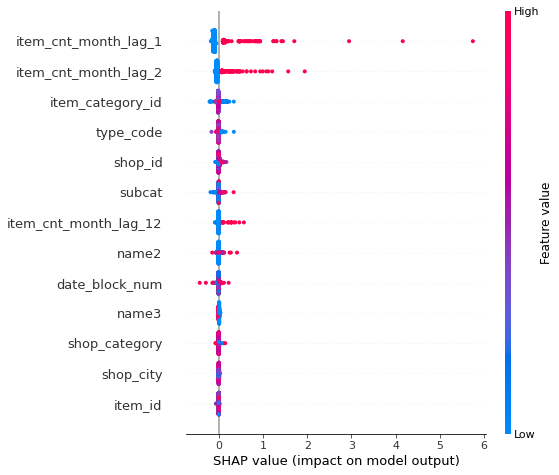

In [16]:
shap.summary_plot(shap_values, X_sampled)

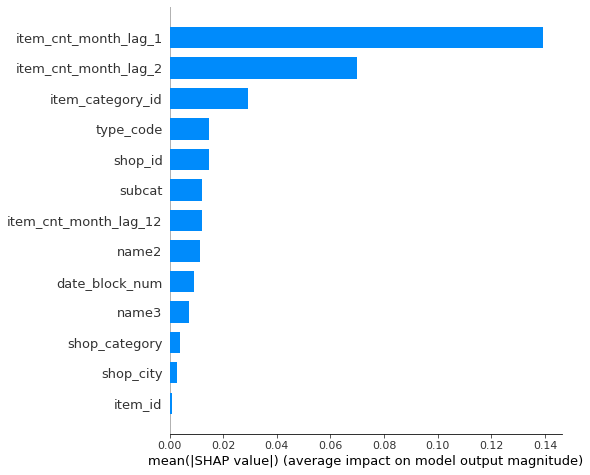

In [17]:
shap.summary_plot(shap_values, X_sampled, plot_type="bar")

Over one prediction

In [18]:
X_sampled = X_train.sample(1, random_state=0)
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_sampled)

In [19]:
shap.force_plot(explainer.expected_value, shap_values, X_sampled)

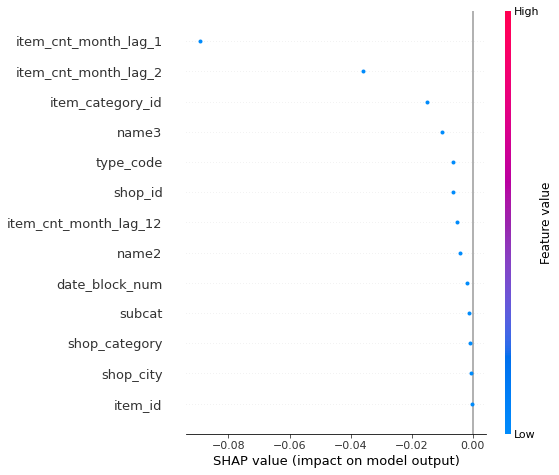

In [20]:
shap.summary_plot(shap_values, X_sampled)

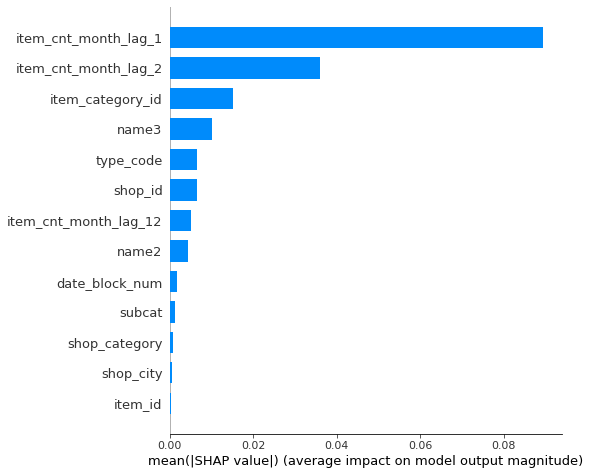

In [21]:
shap.summary_plot(shap_values, X_sampled, plot_type="bar")

## Model error analysis layer

Check for overfitting

In [22]:
results = final_model.evals_result()
epochs = len(results['validation_0']['rmse'])

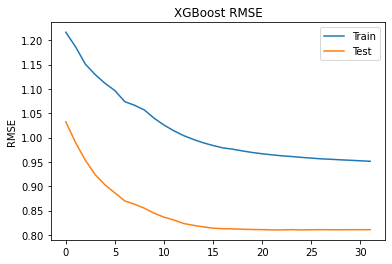

In [23]:
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

This behavior can be explained by the fact, that we've already learnt patterns in data from previous month (for example, if we take 10 month for train and 1 for validation, that results test curve willl be above train) and also by the stochastic processes in the data itself

In [24]:
# train = pd.concat([X_train, y_train], axis=1)
# for month in train.date_block_num.unique():
#     cur_month_data = train[train.date_block_num == month]
#     y_train_cur = cur_month_data.item_cnt_month
#     y_train_predict_cur = final_model.predict(cur_month_data.drop('item_cnt_month', axis=1))
    
#     fig, ax = plt.subplots(1,2)
#     fig.set_size_inches(16, 8)
#     sns.histplot(x=y_train_cur, y=y_train_predict_cur, ax=ax[0]).set(title=mean_squared_error(y_train_cur, y_train_predict_cur, squared=False))
    
#     sns.histplot(x=y_valid, y=y_valid_predict,ax=ax[1]).set(title=mean_squared_error(y_valid, y_valid_predict, squared=False))

In [25]:
y_train_predict = final_model.predict(X_train)

In [26]:
y_valid_predict = final_model.predict(X_valid)

[Text(0.5, 1.0, '0.8104184136483634')]

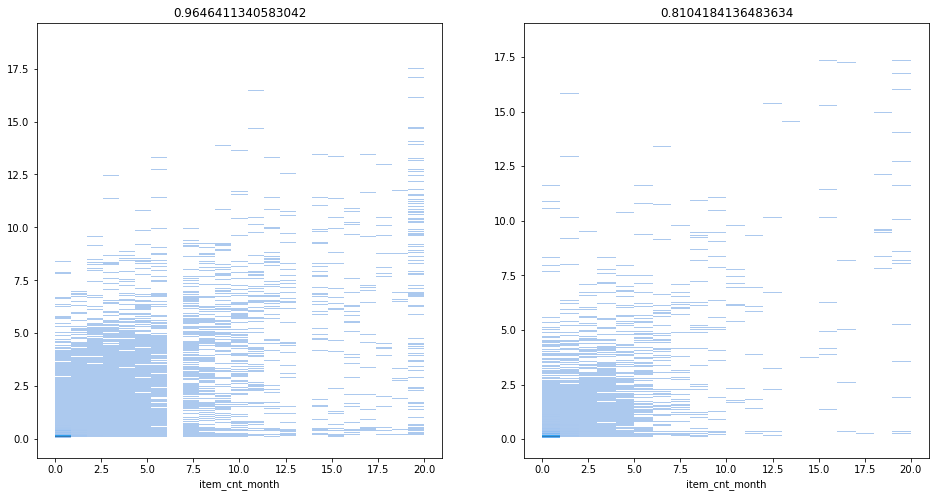

In [27]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16, 8)
sns.histplot(x=y_train, y=y_train_predict, ax=ax[0]).set(title=mean_squared_error(y_train, y_train_predict, squared=False))
sns.histplot(x=y_valid, y=y_valid_predict,ax=ax[1]).set(title=mean_squared_error(y_valid, y_valid_predict, squared=False))

Model predicts big target with much bigger variation than smaller target, it can be explained by the fact that we have very few large values in comparison to the amount of near-zero values.

Targets witn small dynamic are explained much better, with lower variation

In [28]:
item_error_train = []
for i, (pred, actual) in enumerate(zip(y_train_predict, y_train)):
    item_error_train.append((i, np.sqrt(mean_squared_error([actual], [pred], squared=False))))

In [49]:
big_error = list(filter(lambda a: a[1] > 3, item_error_train))
big_error_ind = list(map(operator.itemgetter(0), big_error))

Text(0, 0.5, 'Predicted y values')

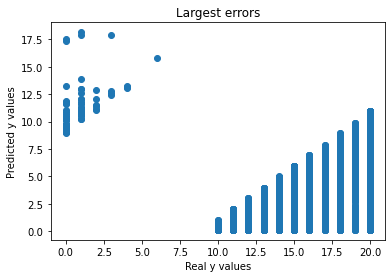

In [51]:
plt.scatter(y_train.iloc[big_error_ind], pd.Series(y_train_predict).iloc[big_error_ind])

plt.title("Largest errors")
plt.xlabel("Real y values")
plt.ylabel("Predicted y values")

In [52]:
y_valid_predict = final_model.predict(X_valid)

In [56]:
item_error_val = []
for i, (pred, actual) in enumerate(zip(y_valid_predict, y_valid)):
    item_error_val.append((i, np.sqrt(mean_squared_error([actual], [pred], squared=False))))

In [58]:
big_error_val = list(filter(lambda a: a[1] > 3, item_error_val))
big_error_val_ind = list(map(operator.itemgetter(0), big_error_val))

Text(0, 0.5, 'Predicted y values')

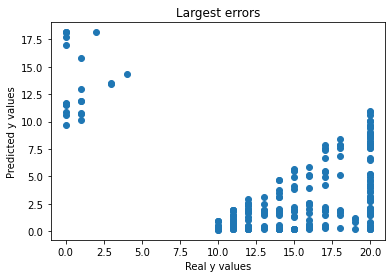

In [60]:
plt.scatter(y_valid.iloc[big_error_val_ind], pd.Series(y_valid_predict).iloc[big_error_val_ind])

plt.title("Largest errors")
plt.xlabel("Real y values")
plt.ylabel("Predicted y values")

## Predictions

In [46]:
train = tscv.train_eng.get_train()

In [47]:
X_test = train[train.date_block_num == 34]

In [48]:
X_test = X_test.drop('item_cnt_month', axis=1)

In [49]:
X_test = X_test.fillna(0)

In [50]:
predictions = final_model.predict(X_test)

In [51]:
submission = {'ID': test.index, 'item_cnt_month': predictions}
submission = pd.DataFrame(submission)

In [52]:
submission.to_csv('submission.csv', index=False)